# Background

In this worksheet, we demonstrate how our theoretical framework can be applied to a pre-existing Environment-Organism (EO) model, that of [Piccardi et al. 2019](https://www.pnas.org/doi/abs/10.1073/pnas.1906172116).

For this model we have the sensitivity function for a species $\alpha$ given as:

$$\frac{1}{s}_\alpha \frac{d s_\alpha}{d t} = g_\alpha(\mathbf{r}) = (1-f_\alpha) \gamma_\alpha - \theta_\alpha$$

and impact functions for a second species $\beta$ (possibly the same as $\alpha$) based on the nutrient $[n]$ and toxin $[q]$ concentrations:

$$\mathbf{f}_\beta(\mathbf{r}) = \begin{bmatrix}
    -\frac{\gamma_\beta}{Y_\beta}\\
    f_\beta \delta_\beta \gamma_\beta [q] + \kappa_\beta
    \end{bmatrix}$$

where

$$\mathbf{r} = \begin{bmatrix}
[n] \\
[q]
\end{bmatrix} $$

and

$$\gamma_\alpha = \nu_{n\alpha} \frac{[n]}{[n] + K_{n\alpha}}$$

$$\theta_\alpha = \nu_{q\alpha} \frac{[q]}{[q] + K_{q\alpha}}.$$

To simplify these equations, we will assume $\kappa_\beta=0$, $Y_\beta = 1$, $K_{n\alpha}=1$ and $K_{q\alpha}=1$. The former can be justified by assuming that the direct absorbtion of the toxin will be weak compared to the degradation effect, the latter by assuming that we non-dimensionalise the relevant parameters (technically only possible for a single species model, but we will be focussing on such a single-species system most of the time).

We can rewrite this as sensitivity and impact functions $g_\alpha(\mathbf{r})$ and $\mathbf{f}_\beta(\mathbf{r})$ as

$$\mathbf{f}_\beta(\mathbf{r}) = \frac{\nu_{n\beta}[n]}{[n] + 1} \begin{bmatrix}
- 1 \\
-[q] f_\beta \delta_\beta
\end{bmatrix}$$

$$g_\alpha (\mathbf{r}) = \frac{(1-f_\alpha) \nu_{n\alpha} [n]}{[n] + 1} - \frac{\nu_{q\alpha} [q]}{[q] + 1}$$

and so

$$\nabla g_\alpha (\mathbf{r}) = \begin{bmatrix}
\frac{(1-f_\alpha)\nu_{n\alpha}}{([n] + 1)^2} \\
\frac{-\nu_{q\alpha}}{([q] + 1)^2}
\end{bmatrix}$$

$$a'_{\alpha \beta} = \nabla g_\alpha (\mathbf{r}) \cdot \mathbf{f}_\beta (\mathbf{r}) = \frac{\nu_{n\beta}[n]}{[n]+1} \left(\nu_{q\alpha} \delta_\beta f_\beta \frac{[q] }{([q] + 1)^2} - (1-f_\alpha)\frac{\nu_{n\alpha}}{([n] + 1)^2}\right).$$

In the first blocks of code below, we reproduce these equations as sensFunc, gradSensFunc and impactFunc.

In [1]:
#Import packages used
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

from matplotlib import cm
from scipy.integrate import solve_ivp
from scipy.interpolate import RectBivariateSpline

In [2]:
#Sensitivity function - rs are resource concs, specInd is the index of the species under consideration, Kms are the half-maximal velocity concentrations and fs are the investment fractions/leakage penalties
def sensFunc(rs,specInd,Kns,Kts,fs,rmaxs,mmaxs):
    monodN = (rmaxs[specInd]*rs[0])/(rs[0]+Kns[specInd])
    monodT = (mmaxs[specInd]*rs[1])/(rs[1]+Kts[specInd])
    
    sens = (1-fs[specInd])*monodN - monodT
    
    return sens

#Gradient of the sensitivity function in the resource space
def gradSensFunc(rs,specInd,Kns,Kts,fs,rmaxs,mmaxs):
    sensGrad = np.zeros(rs.shape)
    
    monodGradN = (rmaxs[specInd]*Kns[specInd])/((rs[0]+Kns[specInd])**2)
    monodGradT = (mmaxs[specInd]*Kts[specInd])/((rs[1]+Kts[specInd])**2)
    
    sensGrad[0] = (1-fs[specInd])*monodGradN
    sensGrad[1] = -monodGradT
    
    return sensGrad

#Impact function for a single species
def impactFunc(rs,specInd,rmaxs,fs,Ys,Kns,deltas):
    impact = np.zeros(rs.shape)
    
    monodN = (rmaxs[specInd]*rs[0])/(rs[0]+Kns[specInd])
    
    impact[0] = -monodN/Ys[specInd]
    impact[1] = -rs[1]*monodN*fs[specInd]*deltas[specInd]
    
    return impact

### Illustration of instantaneous, cumulative and measured interactions
We now use these functions to illustrate the instantaneous intra-specific interaction for a single population $\mathcal{A}$, $a'_{\mathcal{A} \mathcal{A}}$ (Fig. 2B-D)

In [3]:
#Generate interaction array

#Model parameters
Kns = (1,) #Indexed by species
Kts = (1,) #Indexed by species
rmaxs = (0.05,) #Indexed by species
mmaxs = (0.05,) #Indexed by species
Ys = (1,) #Indexed by species
fs = (0.2,) #Indexed by species
deltas = (10,) #Indexed by species

minN = 0
maxN = 5
minT = 0
maxT = 0.5

sampPtsN = 100
sampPtsT = 100

nList = np.linspace(minN,maxN,sampPtsN)
tList = np.linspace(minT,maxT,sampPtsT)

nField, tField = np.meshgrid(nList, tList)

nStep = nField[1,0] - nField[0,0]
tStep = tField[0,1] - tField[0,0]

impacts = np.zeros((sampPtsN,sampPtsT,2)) 
sensitivities = np.zeros((sampPtsN,sampPtsT))
sensGrads = np.zeros((sampPtsN,sampPtsT,2))
sp1on1 = np.zeros((sampPtsN,sampPtsT))

for nInd in range(sampPtsN):
    for tInd in range(sampPtsT):
        r = np.array([nField[nInd,tInd],tField[nInd,tInd]])
        
        impacts[nInd,tInd] = impactFunc(r,0,rmaxs,fs,Ys,Kns,deltas)
        sensitivities[nInd,tInd] = sensFunc(r,0,Kns,Kts,fs,rmaxs,mmaxs)
        sensGrads[nInd,tInd,:] = gradSensFunc(r,0,Kns,Kts,fs,rmaxs,mmaxs)
        
        sp1on1[nInd,tInd] = np.dot(impacts[nInd,tInd],sensGrads[nInd,tInd])

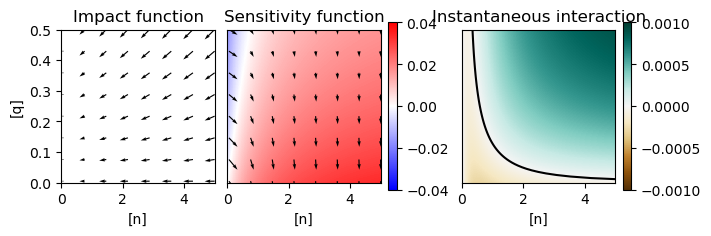

In [4]:
#Plot sensitivity and impact functions
fig, axAr = plt.subplots(nrows = 1, ncols = 3, constrained_layout = True, figsize=(7,2.5))
ax1=axAr[0]
ax2=axAr[1]
ax3=axAr[2]

ptDensity = 7 #How large the spacing between points in the quiver lattice should be

subN = nField[1:sampPtsN:round(sampPtsN/ptDensity),1:sampPtsT:round(sampPtsT/ptDensity)]
subT = tField[1:sampPtsN:round(sampPtsN/ptDensity),1:sampPtsT:round(sampPtsT/ptDensity)]
subSensGradN = sensGrads[1:sampPtsN:round(sampPtsN/ptDensity),1:sampPtsT:round(sampPtsT/ptDensity),0]
subSensGradT = sensGrads[1:sampPtsN:round(sampPtsN/ptDensity),1:sampPtsT:round(sampPtsT/ptDensity),1]
subImpactsN = impacts[1:sampPtsN:round(sampPtsN/ptDensity),1:sampPtsT:round(sampPtsT/ptDensity),0]
subImpactsT = impacts[1:sampPtsN:round(sampPtsN/ptDensity),1:sampPtsT:round(sampPtsT/ptDensity),1]

ax1.quiver(subN,subT,subImpactsN,subImpactsT)
ax1.set_title('Impact function')
ax1.set_xlim((minN,maxN))
ax1.set_ylim((minT,maxT))
ax1.set_aspect(10)
ax1.set_xlabel('[n]')
ax1.set_ylabel('[q]')

img = ax2.imshow(sensitivities,aspect='auto',extent=[minN,maxN,minT,maxT], origin='lower', cmap='bwr', vmin = -0.04, vmax=0.04)
ax2.set_title('Sensitivity function')
fig.colorbar(img, ax=ax2,shrink=0.7)

ax2.quiver(subN,subT,subSensGradN,subSensGradT,color='black')
ax2.set_aspect(10)
ax2.set_xlabel('[n]')
ax2.set_yticks([],[])

#Plot instantaneous interaction array
def findPiccardiNullcline(tField,Kns,Kts,fs,Ys,mmaxs,rmaxs,deltas,alphInd,betInd):
    #alphInd and betInd are species indices as in the notation for the instantaneous interaction, so beta is the impactor and alpha is the impactee
    r2 = tField[1:,0]
    b = 2*Kns[betInd]
    c = Kns[betInd]**2 - np.divide((np.power(r2 + Kts[betInd],2)*(1-fs[betInd])*Kns[betInd]*rmaxs[betInd]),(Ys[alphInd]*r2*fs[alphInd]*deltas[alphInd]*Kts[betInd]*mmaxs[betInd]))
    r1 = (-b + np.sqrt(np.power(b,2) - 4*c))/2
    
    return (r1,r2)

(r1,r2) = findPiccardiNullcline(tField,Kns,Kts,fs,Ys,mmaxs,rmaxs,deltas,0,0)

img = ax3.imshow(sp1on1,cmap='BrBG',aspect='auto',vmin = -0.001, vmax = 0.001,extent=[minN,maxN,minT,maxT], origin='lower')
fig.colorbar(img, ax=ax3, shrink=0.7)

ax3.plot(r1,r2,'k')
ax3.set_aspect(10)
ax3.set_xlim(right=maxN,left=minN)
ax3.set_ylim(top=maxT,bottom=minT)
ax3.set_yticks([],[])

ax3.set_title('Instantaneous interaction')
ax3.set_xlabel('[n]')
plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\IntraspecificInts_Models\\PiccardiImpactSensitivityInteraction.pdf')

Now, having illustrated the environmental-dependence of this quantity, we show how time evolution in batch culture system results in trajectories being swept out over the environment space (Fig. 2E).

In [5]:
#Define function used to generate the values of dY at each timepoint
def batchReact(t, y, rmaxs, mmaxs, Kns, Kts, fs, Ys, deltas):    
    
    #We have three separate populations: The nutrient N, the toxin T and the bacteria X
    r = y[0:2] #Resource vector
    s1 = y[2] #bacteria
    
    sens1 = sensFunc(r,0,Kns,Kts,fs,rmaxs,mmaxs)
    impact1 = impactFunc(r,0,rmaxs,fs,Ys,Kns,deltas)
    
    dr = impact1*s1
    ds1 = sens1*s1
    
    dY = np.concatenate((dr,np.array([ds1])),axis=0)
    return dY

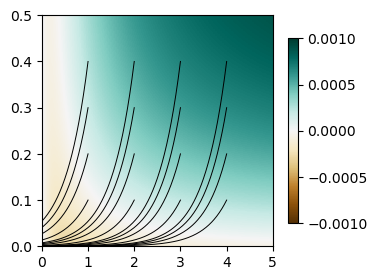

In [6]:
fig1 = plt.figure(figsize=(4,3))
ax1 = plt.gca()
img1 = plt.imshow(sp1on1,cmap='BrBG',aspect='auto',vmin = -0.001, vmax = 0.001,extent=[minN,maxN,minT,maxT], origin='lower')

dN = 1
dT = 0.1

inArgs = (rmaxs, mmaxs, Kns, Kts, fs, Ys, deltas)

#Time settings for the solver
tSpan = [0,1000]
dt = 1
tSteps = np.arange(tSpan[0],tSpan[1],dt)

B0 = 0.01

for N0 in np.arange(minN+dN,maxN,dN):
    for T0 in np.arange(minT+dT,maxT,dT):
 
        #Initial values for each simulated population
        initConds = [N0,T0,B0]
        batchSol = solve_ivp(fun=batchReact, t_span=tSpan, y0=initConds, t_eval=tSteps, args=inArgs)

        solN = batchSol.y[0,:]
        solT = batchSol.y[1,:]
        solX = batchSol.y[2,:]
        plt.plot(solN,solT,color='k',linewidth=0.7)
        #plt.arrow(solN[50],solT[50],solN[55]-solN[50],solT[55]-solT[50],shape='full', length_includes_head=True, head_width=0.2,color='k')

ax1.set_aspect(10)
ax1.set_xlim([minN,maxN])
ax1.set_ylim([minT,maxT])

fig1.colorbar(img1, ax=ax1, shrink=0.8)
plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\IntraspecificInts_Models\\PiccardiInteractionDynamics.pdf')

We can now measure the cumulative interaction $\int^t_0 a'_{\mathcal{A} \mathcal{A}}(\mathbf{r}) \ s_\mathcal{A} \ d\tau$ and show how this varies over time along with the instantaneous interaction $a'_{\mathcal{A} \mathcal{A}}(\mathbf{r})$ (Fig. 2F).

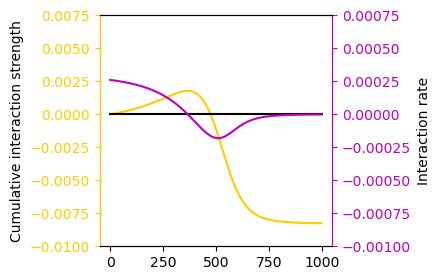

In [7]:
#Illustration of accumulation of positive/negative interactions
fig1 = plt.figure(figsize=(3,3))

#Initial values for each simulated population
N0 = 1
T0 = 0.4
initConds = [N0,T0,B0]
batchSol = solve_ivp(fun=batchReact, t_span=tSpan, y0=initConds, t_eval=tSteps, args=inArgs)

solN = batchSol.y[0,:]
solT = batchSol.y[1,:]
solX = batchSol.y[2,:]

interactRateOverTime = np.zeros(solT.shape)
for i in range(len(solT)):
    r = np.array([solN[i],solT[i]])
    interactRateOverTime[i] = np.dot(impactFunc(r,0,rmaxs,fs,Ys,Kns,deltas),gradSensFunc(r,0,Kns,Kts,fs,rmaxs,mmaxs))
    
interactOverTime = np.cumsum(np.multiply(interactRateOverTime,solX))*dt

plt.plot(tSteps,interactOverTime,color=(1,0.8,0))
plt.plot(tSteps[np.array([0,-1])],[0,0],color='k')

ax1 = plt.gca()
ax1.set_ylim([-0.01,0.0075])
ax1.set_ylabel('Cumulative interaction strength')
ax1.tick_params(axis='y', colors=(1,0.8,0))

ax2 = ax1.twinx()
ax2.plot(tSteps,interactRateOverTime,color='m')
ax2.set_ylim([-0.001,0.00075])
ax2.set_ylabel('Interaction rate')
ax2.spines['right'].set_color('m')
ax2.spines['left'].set_color((1,0.8,0))
ax2.tick_params(axis='y', colors='m')

plt.xlabel('Time')
plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\IntraspecificInts_Models\\PiccardiInteractionAccumulation.pdf')

Integration of this cumulative interaction results in a growth curve. Our experimental measurements of interactions is based on comparisons between growth curves starting from different inoculation densities. The following shows how this comparison works within the model (Fig. S1 A-C).

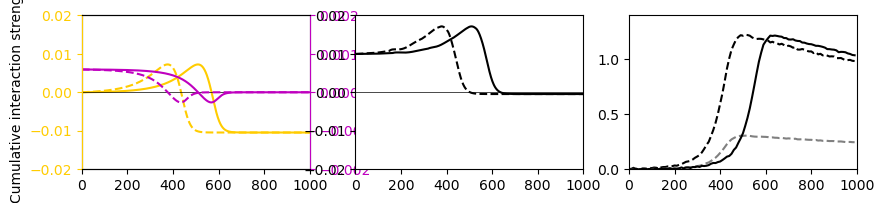

In [66]:
#Demo how the measurement of the self interaction over time actually works
#Initial values for each simulated population
N0 = 2
T0Hi = 0.5
T0Lo = 0
B0Hi = 0.004
B0Lo = 0.001
initCondsB0HiT0Hi = [N0,T0Hi,B0Hi]
initCondsB0LoT0Hi = [N0,T0Hi,B0Lo]
initCondsB0HiT0Lo = [N0,T0Lo,B0Hi]
initCondsB0LoT0Lo = [N0,T0Lo,B0Lo]

tSpan = [0,1000]
dt=1
tSteps = np.arange(tSpan[0],tSpan[1],dt)

batchSolB0HiT0Hi = solve_ivp(fun=batchReact, t_span=tSpan, y0=initCondsB0HiT0Hi, t_eval=tSteps, args=inArgs)
batchSolB0LoT0Hi = solve_ivp(fun=batchReact, t_span=tSpan, y0=initCondsB0LoT0Hi, t_eval=tSteps, args=inArgs)
batchSolB0HiT0Lo = solve_ivp(fun=batchReact, t_span=tSpan, y0=initCondsB0HiT0Lo, t_eval=tSteps, args=inArgs)
batchSolB0LoT0Lo = solve_ivp(fun=batchReact, t_span=tSpan, y0=initCondsB0LoT0Lo, t_eval=tSteps, args=inArgs)

solXB0HiT0Hi = batchSolB0HiT0Hi.y[2,:]
solXB0LoT0Hi = batchSolB0LoT0Hi.y[2,:]
solXB0HiT0Lo = batchSolB0HiT0Lo.y[2,:]
solXB0LoT0Lo = batchSolB0LoT0Lo.y[2,:]

fig = plt.figure(figsize=(10,2))
ax1 = fig.add_subplot(131)

solNB0Hi = batchSolB0HiT0Hi.y[0,:]
solNB0Lo = batchSolB0LoT0Hi.y[0,:]
solTB0Hi = batchSolB0HiT0Hi.y[1,:]
solTB0Lo = batchSolB0LoT0Hi.y[1,:]

#solT[solT<0] = 0
#interactF = RectBivariateSpline(nField[0,:],tField[:,0],sp1on1)
#interactRateOverTimeB0Hi = interactF.ev(solTB0Hi,solNB0Hi)
#interactRateOverTimeB0Lo = interactF.ev(solTB0Lo,solNB0Lo)

interactRateOverTimeB0Hi = np.zeros(solTB0Hi.shape)
interactRateOverTimeB0Lo = np.zeros(solTB0Hi.shape)

for i in range(len(solTB0Hi)):
    r1 = np.array([solNB0Hi[i],solTB0Hi[i]])
    interactRateOverTimeB0Hi[i] = np.dot(impactFunc(r1,0,rmaxs,fs,Ys,Kns,deltas),gradSensFunc(r1,0,Kns,Kts,fs,rmaxs,mmaxs))
    r2 = np.array([solNB0Lo[i],solTB0Lo[i]])
    interactRateOverTimeB0Lo[i] = np.dot(impactFunc(r2,0,rmaxs,fs,Ys,Kns,deltas),gradSensFunc(r2,0,Kns,Kts,fs,rmaxs,mmaxs))
interactOverTimeB0Hi = np.cumsum(np.multiply(interactRateOverTimeB0Hi,solXB0HiT0Hi))*dt
interactOverTimeB0Lo = np.cumsum(np.multiply(interactRateOverTimeB0Lo,solXB0LoT0Hi))*dt
    
#Add a bit of measurement noise to the abundances to demo why we don't use the direct instantaneous interaction estimate
noiseSD = 0.005
measXB0Hi = solXB0HiT0Hi + np.random.normal(scale = noiseSD, size=solXB0HiT0Hi.shape)
measXB0Lo = solXB0LoT0Hi + np.random.normal(scale = noiseSD, size=solXB0LoT0Hi.shape)
measXB0Hi[measXB0Hi < 0] = 0.000001
measXB0Lo[measXB0Lo < 0] = 0.000001

#Subsample to ensure plots don't look awful
tInc = 10
keptSteps = range(int(tSpan[0]/dt),int(tSpan[1]/dt),int(tInc/dt))
measXB0Hi = measXB0Hi[keptSteps]
measXB0Lo = measXB0Lo[keptSteps]
subTs = tSteps[keptSteps]

plt.plot(tSteps,interactOverTimeB0Hi,color=(1,0.8,0),ls='--')
plt.plot(tSteps,interactOverTimeB0Lo,color=(1,0.8,0),ls='-')
plt.plot(tSteps[np.array([0,-1])],[0,0],color='k',lw=0.5)

ax1.set_ylim([-0.02,0.02])
ax1.set_xlim([0,tSpan[1]])
ax1.set_ylabel('Cumulative interaction strength')
ax1.tick_params(axis='y', colors=(1,0.8,0))

ax2 = ax1.twinx()
ax2.plot(tSteps,interactRateOverTimeB0Hi,color='m',ls='--')
ax2.plot(tSteps,interactRateOverTimeB0Lo,color='m',ls='-')
ax2.set_ylim([-0.002,0.002])
ax2.set_xlim([0,tSpan[1]])
ax2.spines['right'].set_color('m')
ax2.spines['left'].set_color((1,0.8,0))
ax2.tick_params(axis='y', colors='m')

ax7 = fig.add_subplot(132)
ax7.plot(tSteps[1:],np.divide(np.diff(solXB0HiT0Hi)/dt,solXB0HiT0Hi[1:]),'k--')
ax7.plot(tSteps[1:],np.divide(np.diff(solXB0LoT0Hi)/dt,solXB0LoT0Hi[1:]),'k')
ax7.plot(tSteps[np.array([0,-1])],[0,0],color='k',lw=0.5)
ax7.set_ylim([-0.02,0.02])
ax7.set_xlim([0,tSpan[1]])

ax3 = fig.add_subplot(133)
ax3.plot(subTs,measXB0Hi,'k--')
ax3.plot(subTs,measXB0Hi/4,'--',color='gray')
ax3.plot(subTs,measXB0Lo,'k')
ax3.set_ylim([0,1.4])
ax3.set_xlim([0,tSpan[1]])

plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\IntraspecificInts_Models\\interactionMeasureDemo.pdf')

We can now consider a number of different types of interaction measurements based on these growth curves - a second-order derivative of the abundance timecourse, a ratio between the sizes of equivalent populations, the time-dependent difference in the area under the abundance curves (AUCs) or the difference between the sizes of equivalent populations (Fig. S1 D-G):

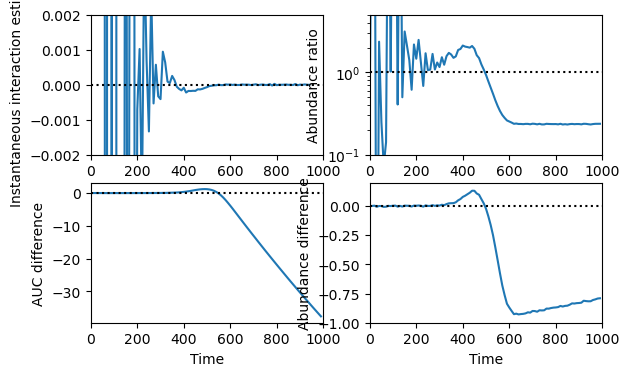

In [67]:
fig = plt.figure(figsize=(6.6,4))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

pcgr = np.divide(np.diff(measXB0Hi),measXB0Hi[1:])/tInc #Per-capita growth rate
window = 10 #Time window between start and end sampling points
instIntEst = np.zeros((pcgr.shape[0]-window,1))
for i in range(pcgr.shape[0]-window):
    g0 = pcgr[i]
    gt = pcgr[i+window]
    cumX = np.sum(measXB0Hi[i:i+window])*tInc
    instIntEst[i] = (gt-g0)/cumX
ax1.plot(subTs[int(window/2)+1:int(-window/2)],instIntEst)

#instIntEst = np.divide(np.diff(np.divide(np.diff(measXB0Hi),measXB0Hi[1:])),measXB0Hi[1:-1])/(tInc**2)
#kernel_size = 10
#kernel = np.ones(kernel_size) / kernel_size
#instIntSmooth = np.convolve(instIntEst, kernel, mode='same')
#ax1.plot(subTs[1:-1],instIntSmooth)
ax1.plot(tSpan,[0,0],'k:')
ax1.set_xlabel('Time')
ax1.set_ylabel('Instantaneous interaction estimate')
ax1.set_xlim([0,tSpan[1]])
ax1.set_ylim([-0.002,0.002])

ax2.plot(subTs,(measXB0Hi/4)/measXB0Lo)
ax2.plot(tSpan,[1,1],'k:')
ax2.set_xlabel('Time')
ax2.set_ylabel('Abundance ratio')
ax2.set_yscale('log')
ax2.set_ylim([0.1,5])
ax2.set_xlim([0,tSpan[1]])

ax3.plot(subTs,np.cumsum(measXB0Hi/4)-np.cumsum(measXB0Lo))
ax3.plot(tSpan,[0,0],'k:')
ax3.set_xlabel('Time')
ax3.set_ylabel('AUC difference')
ax3.set_xlim([0,tSpan[1]])

abundDiff = (measXB0Hi/4) - measXB0Lo
ax4.plot(subTs,abundDiff)
ax4.plot(tSpan,[0,0],'k:')
ax4.set_xlabel('Time')
ax4.set_ylabel('Abundance difference')
ax4.set_xlim([0,tSpan[1]])
ax4.set_ylim([-1,0.2])

plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\IntraspecificInts_Models\\interactionMeasureCandidates.pdf')

We now summarise simulations for systems inoculated under lots of different starting conditions by measuring the peak-positive and final-negative measured interaction strength and plotting as a function of inoculation composition, illustrating both the time-dependence and the environment-dependence of the interaction measurement (Fig. 3H,I):

In [10]:
# Do batch culture simulations at lots of different starting conditions and high and low ODs, then measure the peak and final
# ratios to generate a prediction of the CT intraspecific interaction experiment

#Time settings for the solver
tSpan = [0,1000]
dt = 1
tSteps = np.arange(tSpan[0],tSpan[1],dt)

B0 = 0.001
inocRat = 4 #Density of high-OD well relative to density of low-OD well

sampPtsN = 50
sampPtsT = 50

minN = 0.5 #Set minimal nutrient concentration to discount cases where not enough nutrient is present for system to get going

nList = np.linspace(minN,maxN,sampPtsN)
tList = np.linspace(minT,maxT,sampPtsT)

peaks = np.zeros((sampPtsN,sampPtsT))
finals = np.zeros((sampPtsN,sampPtsT))

for nInd, N0 in enumerate(nList):
    for tInd, T0 in enumerate(tList):
        batchSolMono = solve_ivp(fun=batchReact, t_span=tSpan, y0=[N0,T0,B0], t_eval=tSteps, args=inArgs)
        batchSolCocult = solve_ivp(fun=batchReact, t_span=tSpan, y0=[N0,T0,B0*inocRat], t_eval=tSteps, args=inArgs)
        
        monoDens = batchSolMono.y[2,:]
        coDens = batchSolCocult.y[2,:]
        
        densDiff = coDens/inocRat - monoDens
        
        peaks[nInd,tInd] = max(densDiff)
        finals[nInd,tInd] = densDiff[-1]

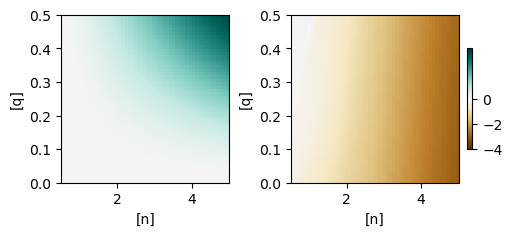

In [11]:
fig, axAr = plt.subplots(nrows = 1, ncols = 2, constrained_layout = True, figsize=(5,2.25))
ax1 = axAr[0]
ax2 = axAr[1]

minN = 0.5

#Set the colourbar scaling so you can see the positive interactions more clearly
divnorm = colors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=0.5)

img1 = ax1.imshow(peaks.T,cmap='BrBG',extent=[minN,maxN,minT,maxT], origin='lower', norm=divnorm)
ax1.set_xlabel('[n]')
ax1.set_ylabel('[q]')
ax1.set_aspect(9)

img2 = ax2.imshow(finals.T,cmap='BrBG',extent=[minN,maxN,minT,maxT],origin='lower',norm=divnorm)
ax2.set_xlabel('[n]')
ax2.set_ylabel('[q]')
ax2.set_aspect(9)
cb = fig.colorbar(img1,ax=ax2,shrink=0.6)

plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\IntraspecificInts_Models\\PiccardiMeasuredInteractions.pdf')

Are these results dependent on fine-tuning of the model parameters? We address this in the below, showing equivalent peak-positive and final-negative interaction maps when the four parameters are either doubled or halved (Fig. S4).

In [ ]:
#Perform the same simulations, but vary the parameters that can't be non-dimensionalised out to show robustness of results.
fig, axAr = plt.subplots(nrows = 4, ncols = 4, constrained_layout = True, figsize=(7,7))

divnorm = colors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=0.5)

for idx, i in enumerate([0,1,4,6]): #Corresponds to varying rmax, mmax, delta and f    
    #Half parameter values
    inArgsTmp = [[*rmaxs], [*mmaxs], [*Kns], [*Kts], [*fs], [*Ys], [*deltas]]
    inArgsTmp[i][0] = inArgs[i][0]/2
    
    peaks = np.zeros((sampPtsN,sampPtsT))
    finals = np.zeros((sampPtsN,sampPtsT))
    
    for nInd, N0 in enumerate(nList):
        for tInd, T0 in enumerate(tList):
            batchSolMono = solve_ivp(fun=batchReact, t_span=tSpan, y0=[N0,T0,B0], t_eval=tSteps, args=inArgsTmp)
            batchSolCocult = solve_ivp(fun=batchReact, t_span=tSpan, y0=[N0,T0,B0*inocRat], t_eval=tSteps, args=inArgsTmp)
        
            monoDens = batchSolMono.y[2,:]
            coDens = batchSolCocult.y[2,:]
        
            densDiff = coDens/inocRat - monoDens
        
            peaks[nInd,tInd] = max(densDiff[np.logical_and(monoDens>0.0005, coDens>0.0005)]) #As we have a density threshold in the experimental analysis code, need to include one here as well to be fair
            finals[nInd,tInd] = densDiff[-1]
    
    pkNorm = cm.colors.Normalize(vmax=abs(peaks).max(), vmin=-abs(peaks).max())
    
    img1 = axAr[idx,0].imshow(peaks.T,cmap='BrBG',extent=[minN,maxN,minT,maxT], origin='lower', norm=divnorm)
    axAr[idx,0].set_ylabel('[n]')
    axAr[idx,0].set_ylabel('[q]')
    axAr[idx,0].set_aspect(9)
    
    img2 = axAr[idx,1].imshow(finals.T,cmap='BrBG',extent=[minN,maxN,minT,maxT], origin='lower', norm=divnorm)
    axAr[idx,1].set_xlabel('[n]')
    axAr[idx,1].set_ylabel('[q]')
    axAr[idx,1].set_aspect(9)
    
    #Double parameter values
    inArgsTmp[i][0] = inArgs[i][0]*2
    
    peaks = np.zeros((sampPtsN,sampPtsT))
    finals = np.zeros((sampPtsN,sampPtsT))
    
    for nInd, N0 in enumerate(nList):
        for tInd, T0 in enumerate(tList):
            batchSolMono = solve_ivp(fun=batchReact, t_span=tSpan, y0=[N0,T0,B0], t_eval=tSteps, args=inArgsTmp)
            batchSolCocult = solve_ivp(fun=batchReact, t_span=tSpan, y0=[N0,T0,B0*inocRat], t_eval=tSteps, args=inArgsTmp)
        
            monoDens = batchSolMono.y[2,:]
            coDens = batchSolCocult.y[2,:]
        
            densDiff = coDens/inocRat - monoDens
        
            peaks[nInd,tInd] = max(densDiff)
            finals[nInd,tInd] = densDiff[-1]
    
    img1 = axAr[idx,2].imshow(peaks.T,cmap='BrBG',extent=[minN,maxN,minT,maxT], origin='lower', norm=divnorm)
    axAr[idx,2].set_xlabel('[n]')
    axAr[idx,2].set_ylabel('[q]')
    axAr[idx,2].set_aspect(9)
    
    img2 = axAr[idx,3].imshow(finals.T,cmap='BrBG',extent=[minN,maxN,minT,maxT], origin='lower', norm=divnorm)
    axAr[idx,3].set_xlabel('[n]')
    axAr[idx,3].set_ylabel('[q]')
    axAr[idx,3].set_aspect(9)

plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\IntraspecificInts_Models\\PiccardiMeasuredInteractions_ParamSweeps.pdf')

[[0.025], [0.05], [1], [1], [0.2], [1], [10]]
[[0.1], [0.05], [1], [1], [0.2], [1], [10]]
[[0.05], [0.025], [1], [1], [0.2], [1], [10]]
[[0.05], [0.1], [1], [1], [0.2], [1], [10]]
[[0.05], [0.05], [1], [1], [0.1], [1], [10]]
[[0.05], [0.05], [1], [1], [0.4], [1], [10]]
[[0.05], [0.05], [1], [1], [0.2], [1], [5.0]]
[[0.05], [0.05], [1], [1], [0.2], [1], [20]]


### Evolutionary model: how does development of resistance affect measured interaction strengths?
In our experiments, we observe that some samples appear to be able to develop enhanced resistance to the antibiotic over experimental timescales. We test the implications of this for our interaction measurements by seeing how evolutionary processes - namely the invasion of an ancestral population by a mutant with altered growth parameters - change the interaction timecourse as well as the peak-positive/final-negative measurements (Fig. S6).

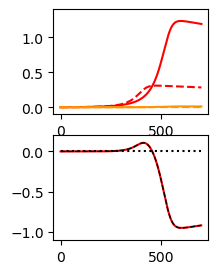

In [13]:
#Evolutionary model - simulate the effect of having a sub-population with higher intrinsic resistance (here) and higher detox rate (next)

#Redefine batch culture model for two populations
def batchReact(t, y, rmaxs, mmaxs, Kns, Kts, fs, Ys, deltas):    
    
    #We have four separate populations: The nutrient N, the toxin T and the two populations of bacteria X
    r = y[0:2] #Resource vector
    s1 = y[2] #bacteria - baseline
    s2 = y[3] #bacteria - resistant population
    
    sens1 = sensFunc(r,0,Kns,Kts,fs,rmaxs,mmaxs)
    impact1 = impactFunc(r,0,rmaxs,fs,Ys,Kns,deltas)
    sens2 = sensFunc(r,1,Kns,Kts,fs,rmaxs,mmaxs)
    impact2 = impactFunc(r,0,rmaxs,fs,Ys,Kns,deltas)
    
    dr = impact1*s1 + impact2*s2
    ds1 = sens1*s1
    ds2 = sens2*s2
    
    dY = np.concatenate((dr,np.array([ds1,ds2])),axis=0)
    return dY

fig = plt.figure(figsize=(2,3))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#Model parameters
Kns = (1,1) #Indexed by species
Kts = (1,1) #Indexed by species
rmaxs = (0.05,0.05) #Indexed by species
mmaxs = (0.05,0.05) #Indexed by species
Ys = (1,1) #Indexed by species
fs = (0.2,0.2) #Indexed by species
deltas = (10,50) #Indexed by species

inArgs = (rmaxs, mmaxs, Kns, Kts, fs, Ys, deltas)

#Initial conditions
N0 = 2
T0 = 0.45

#Time settings for the solver
tSpan = [0,700]
dt = 1
tSteps = np.arange(tSpan[0],tSpan[1],dt)

B0HiBase = [0.004,0]
B0LoBase = [0.001,0]
B0HiRes = [0.00396,0.00004]
B0LoRes = [0.00099,0.00001]
        
initCondsB0HiBase = [N0,T0,*B0HiBase]
initCondsB0LoBase = [N0,T0,*B0LoBase]        
initCondsB0HiRes = [N0,T0,*B0HiRes]
initCondsB0LoRes = [N0,T0,*B0LoRes]

batchSolB0HiBase = solve_ivp(fun=batchReact, t_span=tSpan, y0=initCondsB0HiBase, t_eval=tSteps, args=inArgs)
batchSolB0LoBase = solve_ivp(fun=batchReact, t_span=tSpan, y0=initCondsB0LoBase, t_eval=tSteps, args=inArgs)

#ax1.plot(tSteps,batchSolB0HiBase.y[2,:]/4,'b--')
#ax1.plot(tSteps,batchSolB0LoBase.y[2,:],'b')

batchSolB0HiRes = solve_ivp(fun=batchReact, t_span=tSpan, y0=initCondsB0HiRes, t_eval=tSteps, args=inArgs)
batchSolB0LoRes = solve_ivp(fun=batchReact, t_span=tSpan, y0=initCondsB0LoRes, t_eval=tSteps, args=inArgs)

ax1.plot(tSteps,batchSolB0HiRes.y[2,:]/4,'r--')
ax1.plot(tSteps,batchSolB0LoRes.y[2,:],'r')
ax1.plot(tSteps,batchSolB0HiRes.y[3,:]/4,'--',color='#FF9304')
ax1.plot(tSteps,batchSolB0LoRes.y[3,:],color='#FF9304')
ax2.plot(tSteps,np.sum(batchSolB0HiRes.y[2:4,:],0)/4-(np.sum(batchSolB0LoRes.y[2:4,:],0)),'r',linewidth=1.5)
ax2.plot(tSteps,np.sum(batchSolB0HiBase.y[2:4,:],0)/4-(np.sum(batchSolB0LoBase.y[2:4,:],0)),'k--',linewidth=1)

#ax1.set_yscale('log')
ax2.plot([0,tSpan[1]],[0,0],'k:')
ax1.set_ylim([-0.1,1.4])
ax2.set_ylim([-1.1,0.2])

plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\IntraspecificInts_Models\\Evolution\\deltaShiftGrowthCurves.pdf')

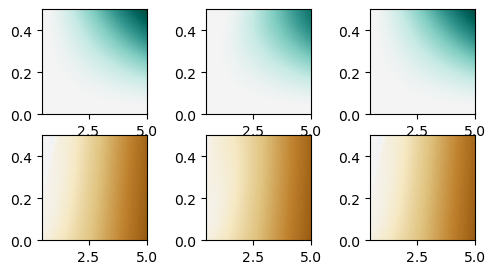

In [14]:
#Generate final and peak interaction heatmaps to compare base and resistance interaction outcomes
fig = plt.figure(figsize=(6,3))
axb1 = fig.add_subplot(231)
axb2 = fig.add_subplot(234)
axm1 = fig.add_subplot(232)
axm2 = fig.add_subplot(235)
axd1 = fig.add_subplot(233)
axd2 = fig.add_subplot(236)

divnorm = colors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=0.5)

#Time settings for the solver
tSpan = [0,1000]
dt = 1
tSteps = np.arange(tSpan[0],tSpan[1],dt)

sampPtsN = 50
sampPtsT = 50

minN = 0.5

nList = np.linspace(minN,maxN,sampPtsN)
tList = np.linspace(minT,maxT,sampPtsT)
      
inArgsBase = (rmaxs, (0.05,0.05), Kns, Kts, fs, Ys, (10,10))
inArgsMuRes = (rmaxs, (0.05,0.01), Kns, Kts, fs, Ys, (10,10))
inArgsDelRes = (rmaxs, (0.05,0.05), Kns, Kts, fs, Ys, (10,50))

peaksBase = np.zeros((sampPtsN,sampPtsT))
finalsBase = np.zeros((sampPtsN,sampPtsT))
peaksMuRes = np.zeros((sampPtsN,sampPtsT))
finalsMuRes = np.zeros((sampPtsN,sampPtsT))
peaksDelRes = np.zeros((sampPtsN,sampPtsT))
finalsDelRes = np.zeros((sampPtsN,sampPtsT))

for nInd, N0 in enumerate(nList):
    for tInd, T0 in enumerate(tList):
        batchSolMonoBase = solve_ivp(fun=batchReact, t_span=tSpan, y0=[N0,T0,*B0LoRes], t_eval=tSteps, args=inArgsBase)
        batchSolCocultBase = solve_ivp(fun=batchReact, t_span=tSpan, y0=[N0,T0,*B0HiRes], t_eval=tSteps, args=inArgsBase)
        batchSolMonoMuRes = solve_ivp(fun=batchReact, t_span=tSpan, y0=[N0,T0,*B0LoRes], t_eval=tSteps, args=inArgsMuRes)
        batchSolCocultMuRes = solve_ivp(fun=batchReact, t_span=tSpan, y0=[N0,T0,*B0HiRes], t_eval=tSteps, args=inArgsMuRes)
        batchSolMonoDelRes = solve_ivp(fun=batchReact, t_span=tSpan, y0=[N0,T0,*B0LoRes], t_eval=tSteps, args=inArgsDelRes)
        batchSolCocultDelRes = solve_ivp(fun=batchReact, t_span=tSpan, y0=[N0,T0,*B0HiRes], t_eval=tSteps, args=inArgsDelRes)
        
        monoDens = batchSolMonoBase.y[2,:] + batchSolMonoBase.y[3,:]
        coDens = batchSolCocultBase.y[2,:] + batchSolCocultBase.y[3,:]
        
        densDiff = coDens/inocRat - monoDens
        
        peaksBase[nInd,tInd] = max(densDiff)
        finalsBase[nInd,tInd] = densDiff[-1]
        
        monoDens = batchSolMonoMuRes.y[2,:] + batchSolMonoMuRes.y[3,:]
        coDens = batchSolCocultMuRes.y[2,:] + batchSolCocultMuRes.y[3,:]
        
        densDiff = coDens/inocRat - monoDens
        
        peaksMuRes[nInd,tInd] = max(densDiff)
        finalsMuRes[nInd,tInd] = densDiff[-1]
        
        monoDens = batchSolMonoDelRes.y[2,:] + batchSolMonoDelRes.y[3,:]
        coDens = batchSolCocultDelRes.y[2,:] + batchSolCocultDelRes.y[3,:]
        
        densDiff = coDens/inocRat - monoDens
        
        peaksDelRes[nInd,tInd] = max(densDiff)
        finalsDelRes[nInd,tInd] = densDiff[-1]

axb1.imshow(peaksBase.T,cmap='BrBG',extent=[minN,maxN,minT,maxT], origin='lower', norm=divnorm)
axb1.set_aspect(9)

axb2.imshow(finalsBase.T,cmap='BrBG',extent=[minN,maxN,minT,maxT],origin='lower',norm=divnorm)
axb2.set_aspect(9)

axm1.imshow(peaksMuRes.T,cmap='BrBG',extent=[minN,maxN,minT,maxT], origin='lower', norm=divnorm)
axm1.set_aspect(9)

axm2.imshow(finalsMuRes.T,cmap='BrBG',extent=[minN,maxN,minT,maxT],origin='lower',norm=divnorm)
axm2.set_aspect(9)

axd1.imshow(peaksDelRes.T,cmap='BrBG',extent=[minN,maxN,minT,maxT], origin='lower', norm=divnorm)
axd1.set_aspect(9)

axd2.imshow(finalsDelRes.T,cmap='BrBG',extent=[minN,maxN,minT,maxT],origin='lower',norm=divnorm)
axd2.set_aspect(9)

plt.savefig('C:\\Users\\omeacock\\OneDrive - Université de Lausanne\\Writing\\Interactions\\Figures\\PDFs\\IntraspecificInts_Models\\Evolution\\evolutionHeatmaps.pdf')

Lastly, we confirm that the results of Piccardi et al. can be reproduced by this implementation as a check that the batch culture simulation setup is working properly.

(0.0, 1.8)

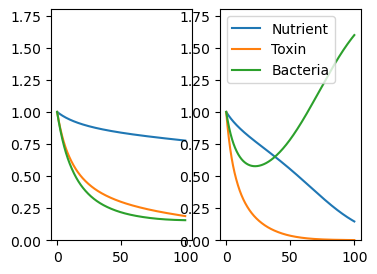

In [15]:
#Check that we can reproduce Fig. 2B of Piccardi et al. as an implementation check

#Model parameters
Kns = (1.5,1.5) #Indexed by species
Kts = (1,1) #Indexed by species
rmaxs = (0.1,0.1) #Indexed by species
mmaxs = (0.2,0.2) #Indexed by species
Ys = (5,5) #Indexed by species
fs = (0.1,0.1) #Indexed by species
deltas = (15,15) #Indexed by species

B0 = 0.5 #Starting concentration of bacteria in batch (biomass)
N0 = 1 #Starting concentration of nutrient
T0 = 1 #Starting concentration of toxin

#Time settings for the solver
tSpan = [0,100]
dt = 0.05
tSteps = np.arange(tSpan[0],tSpan[1],dt)

inArgs = (rmaxs, mmaxs, Kns, Kts, fs, Ys, deltas)

batchSolMono = solve_ivp(fun=batchReact, t_span=tSpan, y0=[N0,T0,B0,B0], t_eval=tSteps, args=inArgs)
batchSolCocult = solve_ivp(fun=batchReact, t_span=tSpan, y0=[N0,T0,B0*2,B0*2], t_eval=tSteps, args=inArgs)

fig = plt.figure(figsize=(4,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(tSteps, batchSolMono.y[0,:])
ax1.plot(tSteps, batchSolMono.y[1,:])
ax1.plot(tSteps, batchSolMono.y[2,:]+batchSolMono.y[3,:])

ax1.set_ylim((0,1.8))

ax2.plot(tSteps, batchSolCocult.y[0,:])
ax2.plot(tSteps, batchSolCocult.y[1,:])
ax2.plot(tSteps, batchSolCocult.y[2,:]/2 + batchSolCocult.y[3,:]/2)
ax2.legend(('Nutrient','Toxin','Bacteria'))

ax2.set_ylim((0,1.8))